# Pytorch-Monitor walkthrough

This notebook serves as an example and test of `pytorch-monitor`.

Pytorch is great. Dynamic computation and module composition make rapid prototyping of new deep learning architectures relatively simple. But as many machine learning engineers know, implementation time amounts to a small fraction of development relative to debugging and train/test evaluation.

For new architectures, we often want to monitor various metrics during training and testing:
* **Model parameter values:** Very large or skewed weight and bias distributions often are a sign of overfitting and small values can be due to underfitting or overregularization.
* **Parameter gradient values:** Viewing gradient distributions for model parameters can shed light on vanishing and exploding gradients.  
* **Model parameter update dynamics:** Understanding how model parameters change as a result of an optimization step can shed light on optimization issues. Consistently small parameter changes can indicate optimization is suffering from poor conditioning and large update values (especially late in training) often coincide with model performance divergences.
* **Intermediate computation activations and gradients:** For deeper or more complicated architectures, it's often useful to monitor intermediate model activation (forward) and jacobian (backward) distributions. This can be crucial in identifying problematic computation nodes and exploding/vanishing gradients.
* **Visualization of computation graph:** Visually inspecting the computation graph can be extremely useful in veryifying that your implementation plays out the same way as you drew it on the whiteboard.

To monitor these metrics we need:
1. Code that indicates the parameters, computations, and gradients to monitor within the model
2. Code that writes summaries of these marked computation nodes efficiently to logfiles
3. Code that provides an interface for inspecting the logs

Tensorboard==1.6 and tensorboardX are great tools for (2) and (3), but the use of tensorboardX for writing summaries of all useful computations (as in (1)) can still be timeconsuming.

This is where pytorch-monitor comes in. It's a simple library which aims to do two things:
1. Initialize and organize experiment logs easily while encouraging reproducability
2. Introspect initialized pytorch `Module`s and endow them with the necessary info to monitor themselves.

Our goal is for this process to be fast with sensible defaults, but flexible enough to allow for changes that meet user needs. With pytorch-monitor you can be off the ground monitoring your network behavior in as little as 2 lines of code.

In [1]:
from pytorch_monitor import init_experiment, monitor_module

## Example 1: The Basics



#### Initializing the experiment

We start by initializing the experiment. Conceptually, an experiment is just the execution of a program and the initial conditions for the program (the `config`).

In [2]:
config = {
    'title':'Test Monitor',
    'log_dir':'test',
    'random_seed':42
}
writer, config = init_experiment(config)
config

{'title': 'Test Monitor',
 'log_dir': 'test',
 'random_seed': 42,
 'run_name': 'May-01-18@12:26:53-dyn-129-236-234-33.dyn.columbia.edu',
 'run_dir': 'test/May-01-18@12:26:53-dyn-129-236-234-33.dyn.columbia.edu',
 'tag': 'Experiment Config: Test Monitor :: May-01-18@12:26:53\n'}

A lot just happened:

We've taken the experiment config dictionary and done the following:
1. Created a `run_name`
2. Created a directory `run_name` in the path `log_dir`
3. If you use git to track your code, curent git repository is automatically commited. This ensures a reproducible snapshot of the code used to run the experiment. 
4. Initialized a tensorboardX `SummaryWriter`.
5. Written a text log to tensorboard that has all initial experiment metadata and configuration, such as start time, host name, random seed, hyperparameters, etc. This can be a very useful when comparing multiple runs in tensorboard.
6. If a `random_seed` is provided, we've set the random seed for python, numpy, and torch all at once.
7. Dumped the config dictionary to file in the `log_dir` as `config.json`.
8. Returned the summary writer and config dictionary, augmented with the `run_name`, `run_dir`, and `tag`.

I've found this initialization strategy to be comprehensive enough for my needs, but I'm sure it could be better. Submit an issue or pull request if you have suggestions!

Next we'll create a simple nonlinear 1-d regression in pytorch. It will take a scalar input x, run it through a nonlinear layer, and produce a scalar output.

We'll train it to predict the sine function. $y = sin(x)$

To do this, first we need some imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()

We'll also generate some simple data.

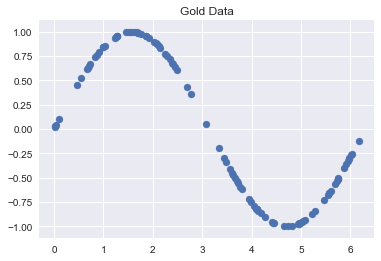

In [4]:
# Get inputs and gold outputs
x = 2 * 3.1415 * torch.rand(100,1)
y = x.sin()

plt.scatter(x.numpy(), y.numpy())
_ = plt.title('Gold Data')

Next, we implement the model. Our model is a simple neural network with one hidden layer of dimension $H$. Mathematically we implement:

$$\hat{y} = W_2 tanh( W_1 x + b_1) $$
where $W_1 \in \mathbb{R}^{H \times 1}$, $b_1 \in \mathbb{R}^{H}$ and $W_2 \in \mathbb{R}^{1 \times H}$, and $tanh$ is the elementwise hyperbolic tangent nonlinearity.

In [5]:
class Model(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.encode = nn.Linear(1, hidden_dim)
        self.decode = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h = F.tanh(self.encode(x))
        
        # Monitor h if we can
        if hasattr(self, 'monitor'):
            self.monitor('h', h, track_data=True, track_grad=True)
            
        yhat = self.decode(h)
        return yhat

#### Monitoring intermediate computations

It's often useful to monitor of the forward and backward passes on intermediate (non-leaf) nodes of model computation.  This can help qualify model behavior at key bottlenecks in complex architectures.

With pytorch-monitor, any monitored module and all of its descendent submodules will be endowed with a `monitor` method having the signature:

```python
monitor(name, tensor, track_data=True, track_grad=True)
```

Once called on a tensor, the monitor method will automatically track the forward and backward pass on the tensor and log it as `<module_name>/<name>` in tensorboard.

One final thing. Pytorch modules don't have the `monitor` method unless they or one of their ancestor modules has been wrapped with `monitor_module` (we'll get to that a little later.) So it is good practice to check that the method exists in your module so the code is compatible with non-monitored networks.

In our code above, we monitor the hidden layer value $h = tanh( W_1 x + b_1)$ with:

```python
if hasattr(self, 'monitor'):
    self.monitor('h', h, track_data=True, track_grad=True)
```

Next, we'll instantiate our network and its parameter optimizer, and finally we *monitor* it.

In [6]:
# Setup the model and optimizer to have 10 hidden units
model = Model(10)
optimizer  = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

# Enable monitoring
monitor_module(model, writer, 
               track_data=True,
               track_grad=True,
               track_update=True,
               track_update_ratio=True)

#### Monitoring the module

The `monitor_module` method is the meat of pytorch-monitor. It introspects the model and configures it to automatically log sensible histogram summaries of all parameters and `monitor`ed intermediate computations using the summary writer returned from `init_experiment`. 

It has the following signature:
```python
monitor_module(model, writer, 
               track_data=True,
               track_grad=True,
               track_update=True,
               track_update_ratio=False)
```

Specifically, by using this function we have:
1. Added extra datastructures and methods to the module, enabling it to properly manage its monitoring state.
2. Added the `monitor` method to all submodules of the module, enabling the monitoring of intermediate computations.
3. Registered function hooks on the parameters and monitored tensors of the module and its submodules. These allow for tensorboard summaries of the various tensors to be logged seamlessly to tensorboard. All `Parameters` are monitored according to the keyword arguments of `monitor_module`. All intermediate tensors are monitored according to their respective `monitor` keywords.

The keyword arguments allow us to customize what we track about the parameters of the model. (Note: Currently we do not allow for tracking different aspects for different parameters, but could be an easy improvement.)

Typically only `track_data` and `track_grad` are necessary, but sometimes it can be useful to monitor module update dynamics with `track_update` and `track_update_ratio`. Specifically, `track_update` will show the true difference in model parameter values from one step to the next. This can shed light on how complex optimizers (such as Adam) are actually affecting the model during training, where the gradient histograms can often be a misleading signal of training behavior because of other update variables like momentum.

#### Monitoring during training

Finally we'll train the model to minimize the mean squared error of its predictions with the true outputs.

During training, we use the summary writer from `init_experiment` to monitor other useful data, such as the loss, and an example of the computation graph on the first run. Check out the [tensorboardX docs](http://tensorboard-pytorch.readthedocs.io/en/latest/tensorboard.html) for a full list of the summary writer's functionality.

The pytorch-monitor logging of parameter and intermediate tensors can be relatively time-consuming because it calculates many histograms. During long training processes this can significantly increase training time.  Monitoring the network behavior at *every* iteration, however, usually isn't necessary, so we'd like to be able to turn monitoring on and off selectively. 

This is why `monitor_module` also sets a `monitoring` method on the model that can be used to toggle the monitoring hooks.  In the example below, we only monitor the network every 500 steps. This is implemented in the lines:

```
if i % monitor_every == 0:
    model.monitoring(True)
else:
    model.monitoring(False)
```

In [ ]:
losses = []
nepochs = 3001
monitor_every = 500

# Plot the models initial predictions
_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4))
ax1.scatter(x.numpy(), y.numpy(), label='Truth', s=25, marker='^')

# Train the model for nepochs
for i in range(nepochs):
    
    # Save the computation graph for the first iteration
    if i == 0:
        writer.add_graph(model, x)
        
    # We only monitor network forward/backward passes 
    # occasionally for efficiency
    if i % monitor_every == 0:
        model.monitoring(True)
        print(i,'...', end=' ')
    else:
        model.monitoring(False)
        
    # Run the model, calculate loss, take a training step
    yhat = model(x)
    loss = ((yhat - y)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Log loss values
    losses.append(loss.item())
    writer.add_scalar('train loss', loss.item(), i)
    
    # Plot predictions at intermediate steps
    if i % (nepochs//2) == 0:
        ax1.scatter(x.numpy(), yhat.detach().numpy(), label='Step {}'.format(i), s=20)

# Plot the learning curve and sample predictions
ax0.plot(list(range(len(losses))), losses)
ax0.set_title('Loss during training')
ax1.set_title('Predictions During Training')
_ = ax1.legend()

0 ... 500 ... 1000 ... 1500 ... 2000 ... 